In [95]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.metrics import mean_squared_error, r2_score
from scipy import stats
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt

In [72]:
master = pd.read_csv("master.csv")
columns_drop = ['Case Number', 'Time', 'Block', 'IUCR', 'Primary Type', 'Description', 'Location Description', 'Arrest', 'Domestic','Beat','District','Ward','Community Area','FBI Code','X Coordinate','Holiday Day of Week',
                'Y Coordinate','Updated On','Latitude','Longitude','Location','precipprob','snowdepth','preciptype', 'windgust','winddir',
                'solarenergy', 'description', 'icon','stations']
data = master.drop(columns=columns_drop)

C:\Users\jbhil\AppData\Local\Temp\ipykernel_12508\207575750.py:1: DtypeWarning: Columns (23,24,36,49,50,52,53,54,55) have mixed types. Specify dtype option on import or set low_memory=False.
  master = pd.read_csv("master.csv")


In [73]:
# Replace NaN values with 0 indicating no holiday and severe risk
data['Holiday'] = data['Holiday'].fillna(0)
data['severerisk'] = data['severerisk'].fillna(0)
# Replace non-NaN values with 1 indicating a holiday
data.loc[data['Holiday'] != 0, 'Holiday'] = 1

# Optionally, convert the 'Holiday' column to integer type
data['Holiday'] = data['Holiday'].astype(int)

In [74]:
# drop dates before 2010 as weather does not have that data
data['Date'] = pd.to_datetime(data['Date'], format='%m/%d/%Y')
data= data[data['Date'].dt.year >= 2010]

# Convert 'sunrise' and 'sunset' columns to datetime format if they aren't already
data['sunrise'] = pd.to_datetime(data['sunrise'])
data['sunset'] = pd.to_datetime(data['sunset'])

# Sort DataFrame by 'Date'
data.sort_values(by='Date', inplace=True)

In [75]:
daily_counts = data.groupby('Date').size().reset_index(name='Crime_Count')


In [76]:
daily_counts

,Date,Crime_Count
0,2010-01-01,74
1,2010-01-02,51
2,2010-01-03,44
3,2010-01-04,52
4,2010-01-05,52
...,...,...
5163,2024-02-20,42
5164,2024-02-21,35
5165,2024-02-22,33
5166,2024-02-23,28


In [77]:
# Merge daily_counts with the original DataFrame
merged_data = pd.merge(data, daily_counts, on='Date')

In [78]:
merged_data['daylight'] = abs(merged_data['sunrise'] - merged_data['sunset'])
merged_data['daylight_hours'] = merged_data['daylight'].dt.total_seconds() / 3600

merged_data['nighttime'] = pd.Timedelta(hours=24) - merged_data['daylight']
merged_data['nighttime_hours'] = merged_data['nighttime'].dt.total_seconds() / 3600

merged_data.drop(['daylight', 'nighttime','sunrise', 'sunset'], axis=1, inplace=True)

In [79]:
# Perform rolling window calculations
merged_data['prev_7_day_avg_Precip'] = merged_data['precip'].rolling(7).mean()
merged_data['prev_7_day_avg_Temp'] = merged_data['temp'].rolling(7).mean()
merged_data['prev_7_day_avg_Daylight'] = merged_data['daylight_hours'].rolling(7).mean()
merged_data['prev_7_day_Snow'] = merged_data['snow'].rolling(7).sum()

In [80]:
merged_data.dropna(inplace=True)

In [81]:
# Drop duplicate rows to keep only one entry per day
final_data = merged_data.drop_duplicates(subset='Date')

In [82]:
final_data.head()

,ID,Date,FullMoon,Holiday,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,...,severerisk,moonphase,conditions,Crime_Count,daylight_hours,nighttime_hours,prev_7_day_avg_Precip,prev_7_day_avg_Temp,prev_7_day_avg_Daylight,prev_7_day_Snow
6,7299080,2010-01-01,0,1,-8.3,-14.5,-11.7,-15.0,-22.4,-19.0,...,0.0,0.53,Partially cloudy,74,9.196389,14.803611,0.0,-11.700000,9.196389,0.0
74,7298303,2010-01-02,0,0,-11.4,-16.4,-14.1,-18.4,-25.3,-22.6,...,0.0,0.57,Partially cloudy,51,9.210000,14.790000,0.0,-12.042857,9.198333,0.0
125,7307156,2010-01-03,0,0,-7.9,-17.5,-12.5,-14.7,-25.6,-20.5,...,0.0,0.60,Partially cloudy,44,9.224444,14.775556,0.0,-13.871429,9.212063,0.0
169,7302079,2010-01-04,0,0,-7.4,-13.1,-10.2,-14.4,-21.3,-17.6,...,0.0,0.64,Overcast,52,9.240000,14.760000,0.0,-12.171429,9.226667,0.0
221,7326331,2010-01-05,0,0,-5.1,-9.5,-7.9,-11.7,-15.9,-14.2,...,0.0,0.67,Overcast,52,9.256667,14.743333,0.0,-9.871429,9.242381,0.0


In [83]:
final_data['conditions'] = final_data['conditions'].str.split(',').apply(lambda x: [c.strip() for c in x])

# Get the set of all unique conditions
unique_conditions = set(condition for sublist in final_data['conditions'] for condition in sublist)

# Create dummy variables for each unique condition
for condition in unique_conditions:
    final_data.loc[:, condition] = final_data['conditions'].apply(lambda x: 1 if condition in x else 0)

# Drop the original 'Conditions' column
final_data.drop(columns=['conditions'], inplace=True)

C:\Users\jbhil\AppData\Local\Temp\ipykernel_12508\2593382681.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_data['conditions'] = final_data['conditions'].str.split(',').apply(lambda x: [c.strip() for c in x])
C:\Users\jbhil\AppData\Local\Temp\ipykernel_12508\2593382681.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_data.loc[:, condition] = final_data['conditions'].apply(lambda x: 1 if condition in x else 0)
C:\Users\jbhil\AppData\Local\Temp\ipykernel_12508\2593382681.py:8: SettingWithC

In [94]:
final_data['Crime_Count']

6         74
74        51
125       44
169       52
221       52
          ..
261676    42
261718    35
261753    33
261786    28
261814    37
Name: Crime_Count, Length: 5168, dtype: int64

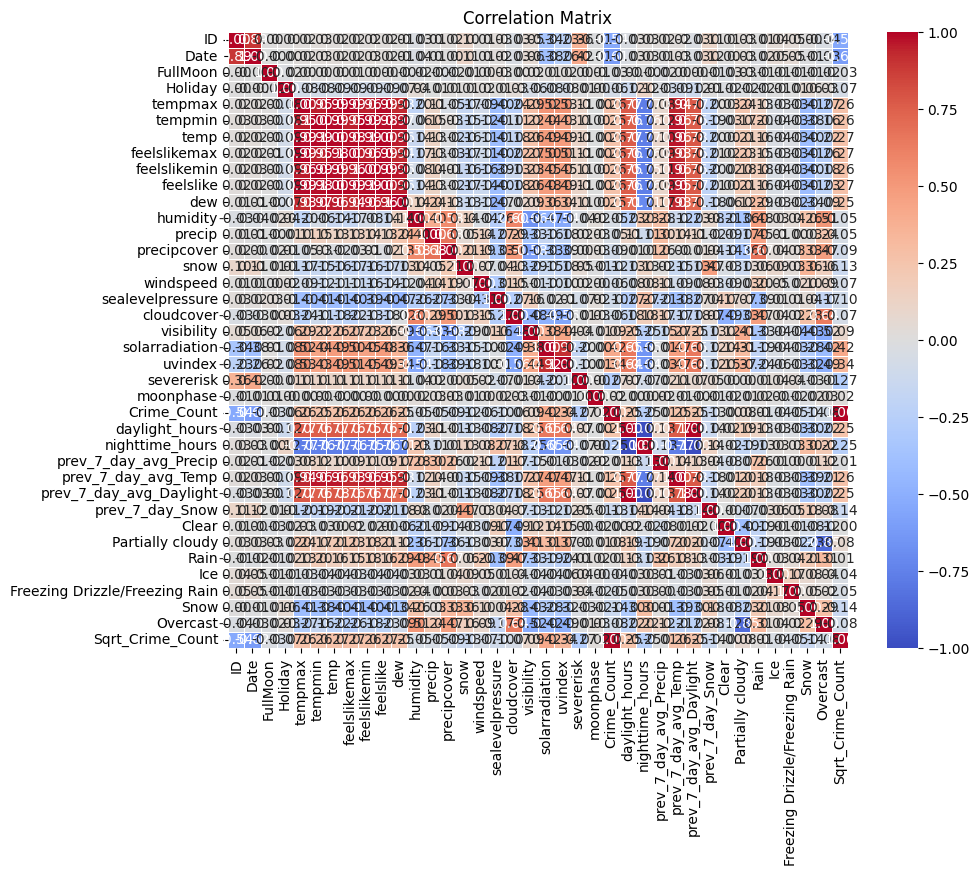

In [135]:
# Calculate the correlation matrix
correlation_matrix = final_data.corr()

# Visualize the correlation matrix using a heatmap
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

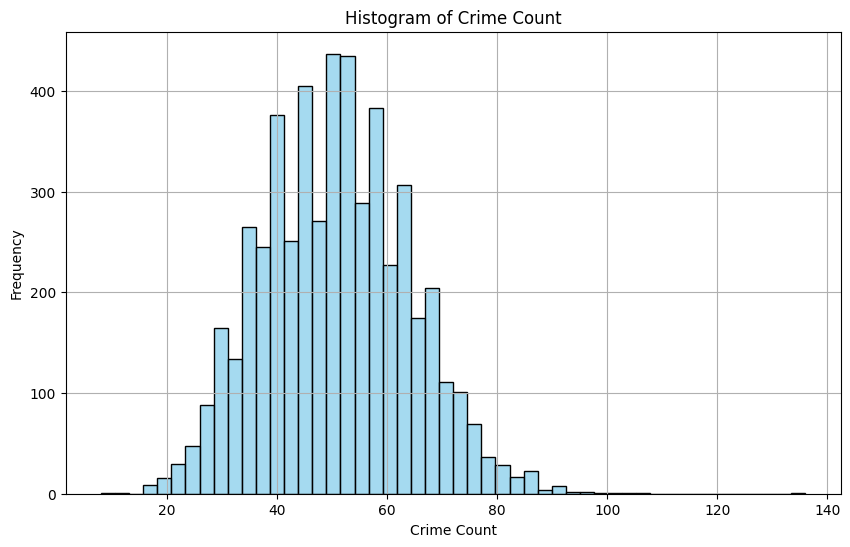

In [99]:
# Create histogram using Seaborn
plt.figure(figsize=(10, 6))
sns.histplot(final_data['Crime_Count'], bins=50, color='skyblue', edgecolor='black')
plt.title('Histogram of Crime Count')
plt.xlabel('Crime Count')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

C:\Users\jbhil\AppData\Local\Temp\ipykernel_12508\508659077.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_data['Sqrt_Crime_Count'] = np.sqrt(final_data['Crime_Count'])


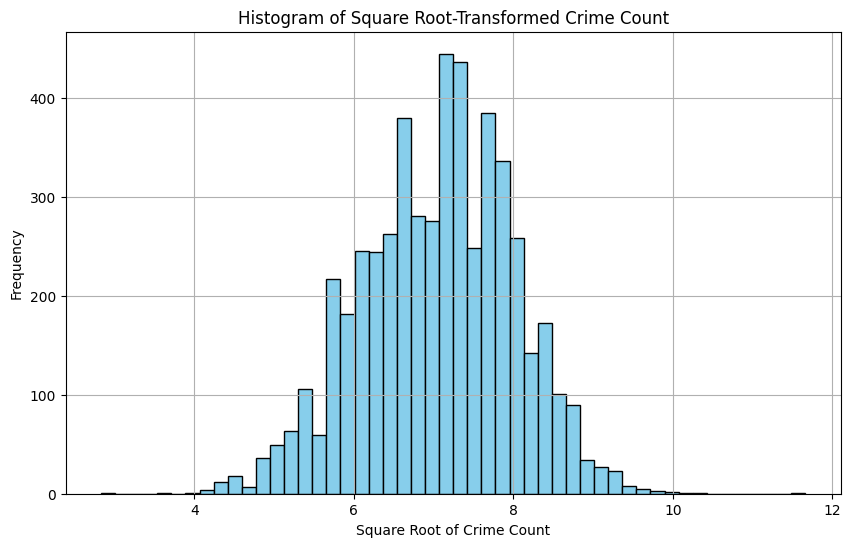

In [110]:
# Apply square root transformation to Crime_Count
final_data['Sqrt_Crime_Count'] = np.sqrt(final_data['Crime_Count'])

# Plot histogram of square root-transformed Crime_Count
plt.figure(figsize=(10, 6))
plt.hist(final_data['Sqrt_Crime_Count'], bins=50, color='skyblue', edgecolor='black')
plt.title('Histogram of Square Root-Transformed Crime Count')
plt.xlabel('Square Root of Crime Count')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [113]:
final_data.to_csv('test_jake.csv', index=False)

X = final_data.drop(columns=['Sqrt_Crime_Count','Crime_Count', 'ID', 'Date'])

# Extract the target variable
y = final_data['Crime_Count']
y_sqrt = final_data['Sqrt_Crime_Count']

numeric_features = X.select_dtypes(include=['number', 'bool']).columns
categorical_features = X.select_dtypes(include=['object']).columns
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_sqrt, test_size=0.2, random_state=42)

In [105]:
X

,FullMoon,Holiday,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,...,prev_7_day_avg_Temp,prev_7_day_avg_Daylight,prev_7_day_Snow,Clear,Partially cloudy,Rain,Ice,Freezing Drizzle/Freezing Rain,Snow,Overcast
6,0,1,-8.3,-14.5,-11.7,-15.0,-22.4,-19.0,-16.1,69.8,...,-11.700000,9.196389,0.0,0,1,0,0,0,0,0
74,0,0,-11.4,-16.4,-14.1,-18.4,-25.3,-22.6,-19.6,63.1,...,-12.042857,9.198333,0.0,0,1,0,0,0,0,0
125,0,0,-7.9,-17.5,-12.5,-14.7,-25.6,-20.5,-17.6,66.0,...,-13.871429,9.212063,0.0,0,1,0,0,0,0,0
169,0,0,-7.4,-13.1,-10.2,-14.4,-21.3,-17.6,-14.6,69.8,...,-12.171429,9.226667,0.0,0,0,0,0,0,0,1
221,0,0,-5.1,-9.5,-7.9,-11.7,-15.9,-14.2,-12.3,70.8,...,-9.871429,9.242381,0.0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
261676,0,0,14.2,-0.7,6.9,14.2,-3.1,5.6,-2.3,55.6,...,3.557143,10.788849,0.0,1,0,0,0,0,0,0
261718,0,0,18.5,7.8,12.3,18.5,5.0,11.3,1.8,49.6,...,7.671429,10.833413,0.0,0,1,0,0,0,0,0
261753,0,0,15.5,8.4,10.9,15.5,6.8,10.2,0.5,49.6,...,12.100000,10.878690,0.0,0,1,0,0,0,0,0
261786,0,0,10.6,-1.8,4.9,10.6,-9.2,1.1,-1.6,64.5,...,10.042857,10.923968,0.7,0,1,1,0,0,1,0


In [114]:
y

6         74
74        51
125       44
169       52
221       52
          ..
261676    42
261718    35
261753    33
261786    28
261814    37
Name: Crime_Count, Length: 5168, dtype: int64

In [115]:
y_sqrt

6         8.602325
74        7.141428
125       6.633250
169       7.211103
221       7.211103
            ...   
261676    6.480741
261718    5.916080
261753    5.744563
261786    5.291503
261814    6.082763
Name: Sqrt_Crime_Count, Length: 5168, dtype: float64

In [108]:
# Fit linear regression model
X_train = sm.add_constant(X_train)  # Add constant to X_train
model = sm.OLS(y_train, X_train)    # Create model
results = model.fit()               # Fit model
print(results.summary())

# Make predictions on the test set
X_test = sm.add_constant(X_test)  # Add constant to X_test
y_pred = results.predict(X_test)  # Predict using the fitted model

# Calculate MSE
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error (MSE):", mse)

# Calculate R^2 score
r2 = r2_score(y_test, y_pred)
print("R^2 Score:", r2)

                            OLS Regression Results                            
Dep. Variable:       Sqrt_Crime_Count   R-squared:                       0.291
Model:                            OLS   Adj. R-squared:                  0.285
Method:                 Least Squares   F-statistic:                     51.00
Date:                Tue, 26 Mar 2024   Prob (F-statistic):          1.42e-276
Time:                        21:50:51   Log-Likelihood:                -4936.6
No. Observations:                4134   AIC:                             9941.
Df Residuals:                    4100   BIC:                         1.016e+04
Df Model:                          33                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

In [90]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

In [1]:
# Define the parameter grid
param_grid = {
    'learning_rate': [0.015, 0.02, 0.025],
    'max_depth': [2, 3, 4],
    'n_estimators': [200, 250, 300],
    'subsample': [0.6, 0.7, 0.8],
}

# Initialize XGBoost regressor
xgb_model = xgb.XGBRegressor(random_state=42)

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error', verbose=2)
grid_search.fit(X_train, y_train)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = -grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Mean Squared Error:", best_score)

NameError: name 'xgb' is not defined